# Data Preprocessing: Developer Stress Dataset

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Load and Explore Data

In [69]:
df = pd.read_csv('developer_stress.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData Types:\n{df.dtypes}")

Dataset Shape: (500, 11)

First few rows:
   Hours_Worked  Sleep_Hours  Bugs  Deadline_Days  Coffee_Cups  Meetings  \
0            10            8    25             53            4         9   
1             7            8    33             33            2         6   
2            14            8    44             54           10        12   
3            11            6     5             46            0        13   
4             8            7    36             23            9         3   

   Interruptions Experience_Years Code_Complexity Remote_Work  Stress_Level  
0              2           Senior          Medium         Yes     58.521033  
1              9           Junior          Medium         Yes     47.461651  
2              2           Junior             Low          No     59.211580  
3              9              Mid             Low         Yes    100.000000  
4              2           Junior          Medium         Yes     28.784957  

Data Types:
Hours_Worked        

## 2. Check for Duplicates and Invalid Data

In [51]:
duplicates = df.duplicated().sum()
df_cleaned = df.drop_duplicates()
print(f"Duplicates removed: {duplicates}")
print(f"Shape after cleaning: {df_cleaned.shape}")

df_cleaned = df_cleaned[(df_cleaned['Sleep_Hours'] >= 0) & (df_cleaned['Sleep_Hours'] <= 24)]
df_cleaned = df_cleaned[(df_cleaned['Hours_Worked'] >= 0) & (df_cleaned['Hours_Worked'] <= 24)]

Duplicates removed: 0
Shape after cleaning: (500, 11)


## 3. Handle Missing Values

In [52]:
missing_count = df_cleaned.isnull().sum().sum()
print(f"Missing values: {missing_count}")

if missing_count > 0:
    numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
    
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

Missing values: 0


## 4. Detect and Handle Outliers

Detecting outliers using IQR method:


Shape before removing outliers: (500, 11)
Shape after removing outliers: (500, 11)
Removed 0 rows with outliers


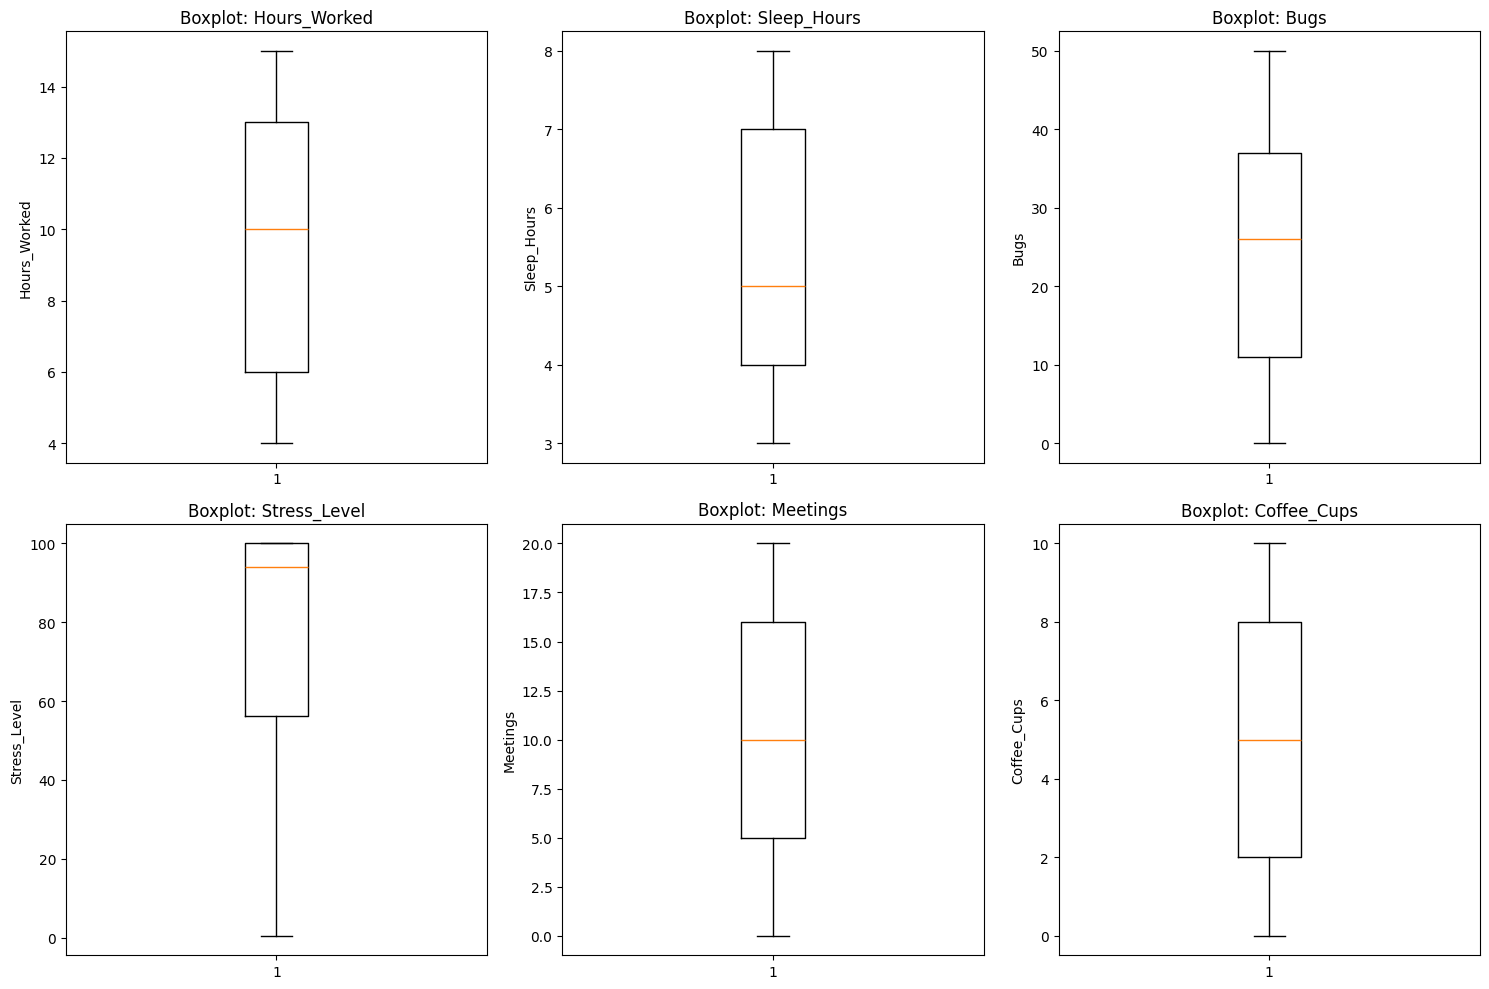

In [53]:
# Detect outliers using IQR method
print("Detecting outliers using IQR method:\n")
df_no_outliers = df_cleaned.copy()

numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns
outlier_counts = {}

for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)).sum()
    if outliers > 0:
        outlier_counts[col] = outliers
        print(f"{col}: {outliers} outliers (bounds: {lower_bound:.2f} - {upper_bound:.2f})")
    
    # Remove outliers (optional: can also cap them)
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

print(f"\nShape before removing outliers: {df_cleaned.shape}")
print(f"Shape after removing outliers: {df_no_outliers.shape}")
print(f"Removed {df_cleaned.shape[0] - df_no_outliers.shape[0]} rows with outliers")

# Visualize outliers for key columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
plot_cols = ['Hours_Worked', 'Sleep_Hours', 'Bugs', 'Stress_Level', 'Meetings', 'Coffee_Cups']

for idx, col in enumerate(plot_cols):
    axes[idx].boxplot(df_cleaned[col])
    axes[idx].set_title(f'Boxplot: {col}')
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

df_cleaned = df_no_outliers.reset_index(drop=True)

## 5. Feature Encoding (Categorical to Numerical)

In [66]:
# Identify categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)
print("\nUnique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df_cleaned[col].unique()}")

# Encode ordinal feature (Experience_Years)
experience_mapping = {'Junior': 1, 'Mid': 2, 'Senior': 3}
df_encoded = df_cleaned.copy()
df_encoded['Experience_Years'] = df_encoded['Experience_Years'].map(experience_mapping)

print("\nAfter encoding:")
print(f"Shape: {df_encoded.shape}")

Categorical columns: ['Experience_Years', 'Code_Complexity', 'Remote_Work']

Unique values in categorical columns:
Experience_Years: ['Senior' 'Junior' 'Mid']
Code_Complexity: ['Medium' 'Low' 'High']
Remote_Work: ['Yes' 'No']

After encoding:
Shape: (500, 11)


## 6. Feature Scaling/Normalization

Features scaled: (500, 8)


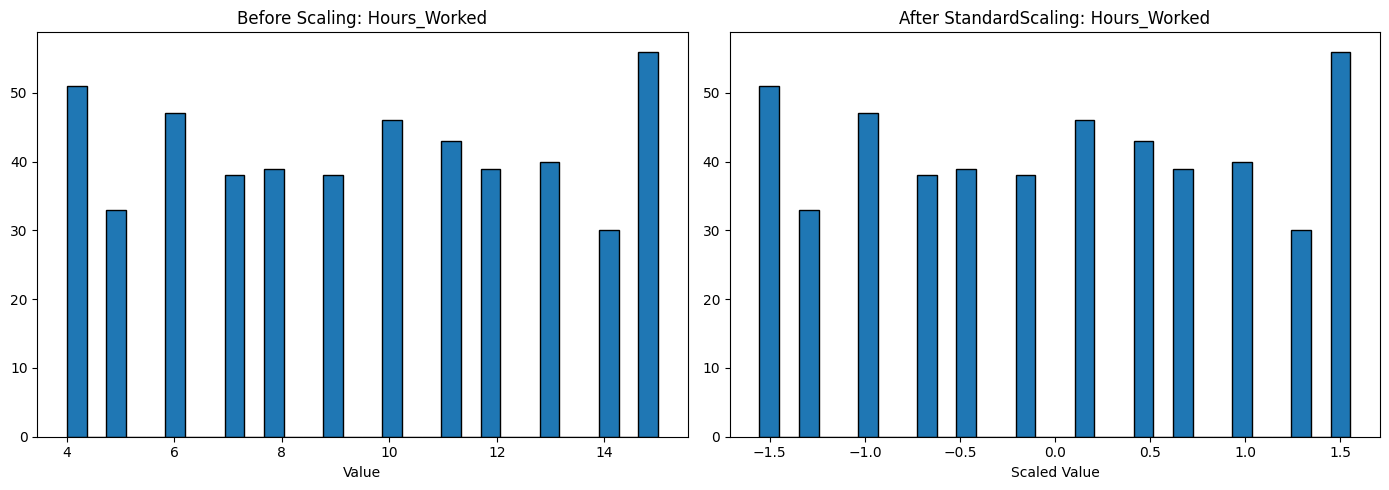

In [59]:
# Separate features and target
df_encoded['Stress_Level'] = LabelEncoder().fit_transform(df_encoded['Stress_Level'])
X = df_encoded.drop('Stress_Level', axis=1)
y = df_encoded['Stress_Level']

# Select only numeric columns for scaling
X = X.select_dtypes(include=[np.number])

scaler_standard = StandardScaler()
X_scaled_standard = scaler_standard.fit_transform(X)
X_scaled = X_scaled_standard
print(f"Features scaled: {X.shape}")

# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].hist(X.iloc[:, 0], bins=30, edgecolor='black')
axes[0].set_title(f'Before Scaling: {X.columns[0]}')
axes[0].set_xlabel('Value')

# After scaling
axes[1].hist(X_scaled[:, 0], bins=30, edgecolor='black')
axes[1].set_title(f'After StandardScaling: {X.columns[0]}')
axes[1].set_xlabel('Scaled Value')

plt.tight_layout()
plt.show()

## 7. Analyze Correlations and Detect Multicollinearity

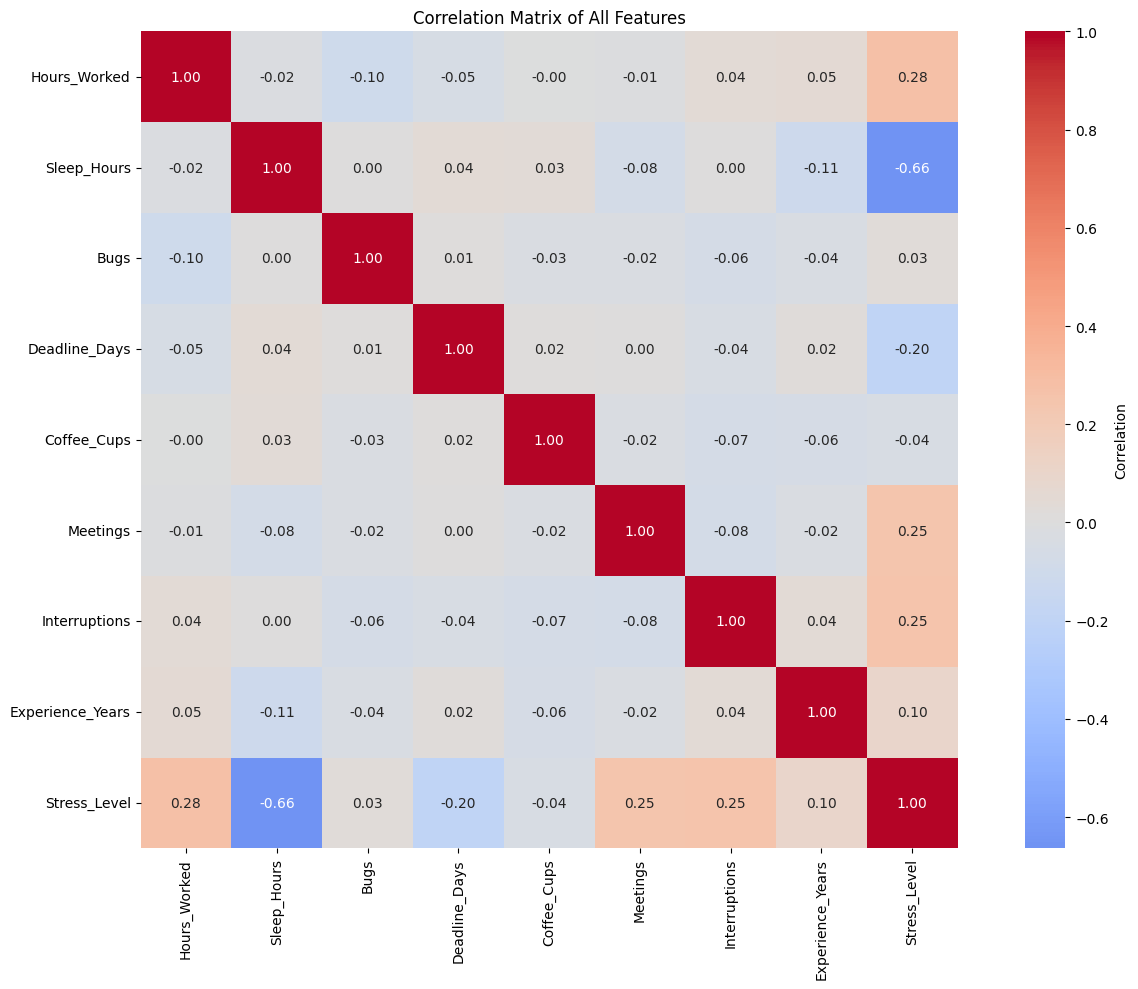

In [63]:
# Calculate correlation matrix (only numeric columns)
correlation_matrix = df_encoded.select_dtypes(include=[np.number]).corr()

# Visualize correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Correlation'}, square=True)
plt.title('Correlation Matrix of All Features')
plt.tight_layout()
plt.show()



## 8. Train-Test Split

In [68]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_updated, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")


Training set size: 400 (80.0%)
Testing set size: 100 (20.0%)
